# Step-1 Business Problem understanding 

- Based on given car features, predict the selling price of used car.  
- required R2 is 0.85 on both train and test.  


In [1]:
import re
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from datetime import datetime
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_excel("cars_data.xlsx")
df.head()

,Name,Price,Rating,city,Kilometers,Year_of_Purchase,Owner,Fuel_Type,Transmission,RTO,Insurance,Insurance_Type
0,2010 Maruti Alto LXI,"₹ 174,699",4out of 5,3686,"Kilometers34,854 km",Year of PurchaseMay 2010,OwnerFirst Owner,FuelPetrol,TransmissionMANUAL,RTOAP09,NaN,Insurance TypeInsurance Expired
1,2013 Maruti Wagon R 1.0 VXI,"₹ 333,999",4.2out of 5,3686,"Kilometers39,541 km",Year of PurchaseJuly 2013,OwnerSecond Owner,FuelPetrol,TransmissionMANUAL,RTOAP28,Insurance6/8/2021,Insurance TypeComp
2,2014 Maruti Wagon R 1.0 VXI,"₹ 353,199",4.3out of 5,3686,"Kilometers23,233 km",Year of PurchaseMarch 2014,OwnerSecond Owner,FuelPetrol,TransmissionMANUAL,RTOAP28,Insurance28/4/2021,Insurance TypeComp
3,2013 Hyundai Eon D LITE PLUS,"₹ 237,899",4.4out of 5,3686,"Kilometers27,748 km",Year of PurchaseNovember 2013,OwnerFirst Owner,FuelPetrol,TransmissionMANUAL,RTOAP13,Insurance1/1/2022,Insurance TypeComp
4,2017 Hyundai Eon ERA PLUS,"₹ 300,699",4.4out of 5,3686,"Kilometers12,238 km",Year of PurchaseAugust 2017,OwnerSecond Owner,FuelPetrol,TransmissionMANUAL,RTOTS10,NaN,Insurance TypeExpired


# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32158 entries, 0 to 32157
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              32158 non-null  object
 1   Price             32158 non-null  object
 2   Rating            32158 non-null  object
 3   city              32158 non-null  int64 
 4   Kilometers        32158 non-null  object
 5   Year_of_Purchase  32158 non-null  object
 6   Owner             32158 non-null  object
 7   Fuel_Type         32158 non-null  object
 8   Transmission      29342 non-null  object
 9   RTO               32158 non-null  object
 10  Insurance         22965 non-null  object
 11  Insurance_Type    32158 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.9+ MB


In [4]:
df.columns

Index(['Name', 'Price', 'Rating', 'city', 'Kilometers', 'Year_of_Purchase',
       'Owner', 'Fuel_Type', 'Transmission', 'RTO', 'Insurance',
       'Insurance_Type'],
      dtype='object')

# Features:  

**Independent variables**  
- **Name**: Car Model name along with purchase year of the car. 
- **Rating**: Rating given while car inspection by cars 24 team.  
- **City**: City of that car placed for advertainment, city is given interms of  code format. 
- **Kilometres**: How many kilometres that particular car has driven for  before placing that advertisement. 
- **Year of purchase**: Original Date of purchase of that car. 
- **Owner**: How many previous owners it had before selling on cars24 site. 
- **Fuel type**: Type of fuel which car runs on.(Petrol, diesel …)  
- **Transmission**: whether car is automated or manual transmission. 
- **RT0**: Car registered under which RTO 
- **Insurance**: expiry date of the insurance if any 
- **Insurance Type**: Different types insurance availed by owner.   

**Target**:  
- **Price**: Price of the

In [5]:
d_type = dict(df.dtypes)
for name, type in d_type.items():
    if str(type) == 'object':
        print(f"<==============={name}============>")
        print(df[name].value_counts())

<===============Name============>
Name
2012 Mahindra XUV500 W8 FWD              105
2009 Maruti Alto LXI                      89
2012 Maruti Swift VDI                     88
2013 Maruti Swift VDI                     76
2007 Maruti Alto LXI                      75
                                        ... 
2018 Mahindra XUV500 W11 MT(O) AWD         1
2009 Honda City ZX GXI                     1
2012 Mahindra Maxximo 7 Seater             1
2012 Skoda Rapid AMBITION 1.6 MPFI AT      1
2007 Mercedes Benz C Class 220 CDI AT      1
Name: count, Length: 6885, dtype: int64
<===============Price============>
Price
₹ 300,000      731
₹ 250,000      698
₹ 350,000      683
₹ 400,000      668
₹ 200,000      603
              ... 
₹ 1,714,750      1
₹ 2,812,000      1
₹ 300,104        1
₹ 1,348,000      1
₹ 96,500         1
Name: count, Length: 4822, dtype: int64
<===============Rating============>
Rating
4.2out of 5    3050
4out of 5      2846
4.1out of 5    2833
4.3out of 5    2775
3.9out of 5  

In [6]:
df["city"].unique()

array([3686, 5732, 4709,  777, 2423, 2378,  290, 1692, 2130,  769],
      dtype=int64)

# Exploratory Data Analysis

In [7]:
df.describe(include="object")

,Name,Price,Rating,Kilometers,Year_of_Purchase,Owner,Fuel_Type,Transmission,RTO,Insurance,Insurance_Type
count,32158,32158,32158,32158,32158,32158,32158,29342,32158,22965,32158
unique,6885,4822,38,29089,343,10,6,2,777,921,12
top,2012 Mahindra XUV500 W8 FWD,"₹ 300,000",4.2out of 5,"Kilometers100,000 km",Year of PurchaseJanuary 2012,OwnerFirst Owner,FuelDiesel,TransmissionMANUAL,RTOGJ01,Insurance29/3/2021,Insurance TypeComprehensive
freq,105,731,3050,39,536,19324,15121,26620,2345,119,6506


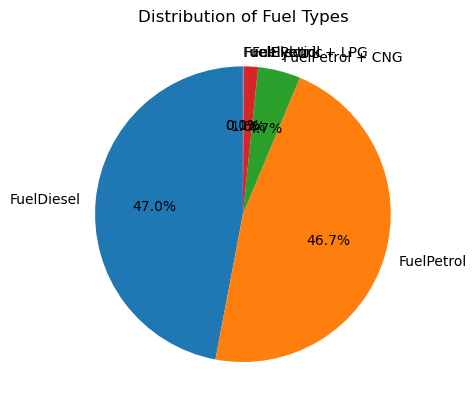

In [8]:
# Count the number of cars for each fuel type
fuel_counts = df['Fuel_Type'].value_counts()

# Create a pie chart
plt.pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Fuel Types')
plt.show()

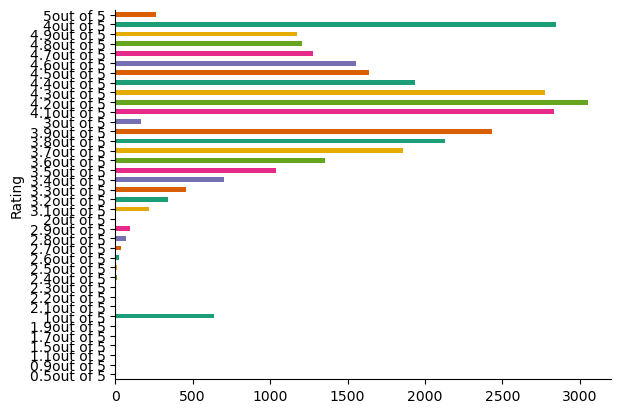

In [9]:
#Representation of Rating 
df.groupby('Rating').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

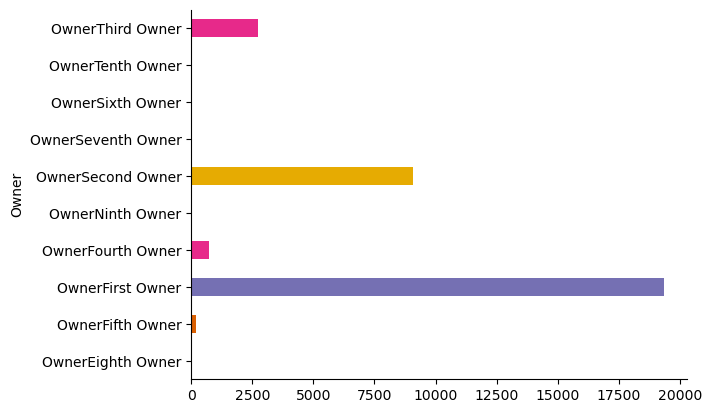

In [10]:
#Representation of Owner
df.groupby('Owner').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

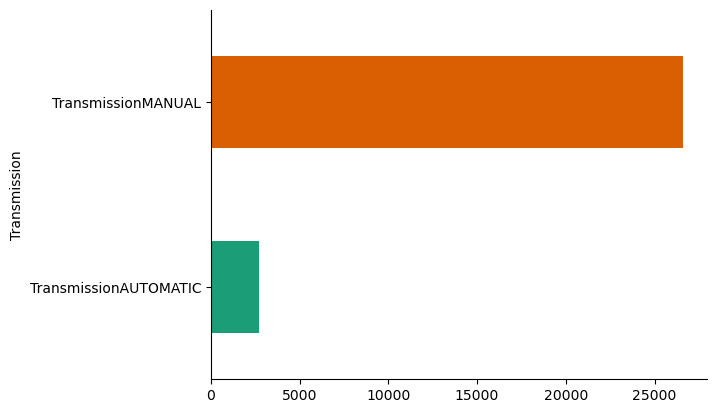

In [11]:
df.groupby('Transmission').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

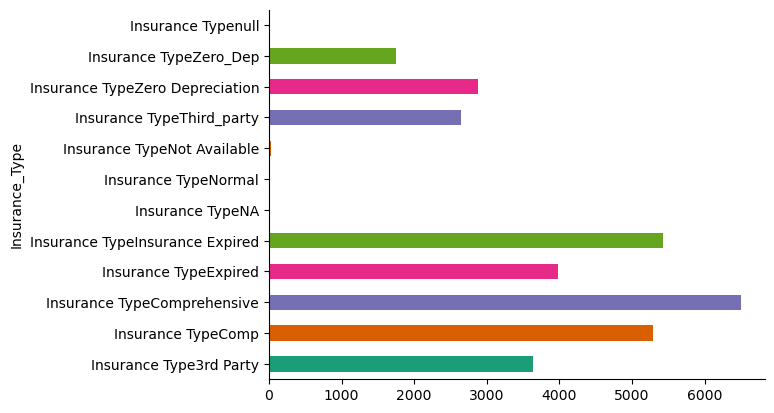

In [12]:
df.groupby('Insurance_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

# Not much opprtunity to inference hence doing data clearning first

In [13]:
#extracting the company name from the Name Column
df['Car_Company'] = df['Name'].apply(lambda x: ' '.join(x.split()[1:2]))
df['Price'] = df['Price'].apply(lambda x: ' '.join(x.split()[1:]))
df['Rating'] = df['Rating'].str.extract(r'(\d+(\.\d+)?)')[0].astype(float)
df['Kilometers'] = df['Kilometers'].str.extract(r"Kilometers(\d{1,3}(,\d{3})*) km")[0]
df['Owner'] = df['Owner'].str.replace(r'^Owner|Owner$', '', regex=True).str.strip()
df['Fuel_Type'] = df['Fuel_Type'].str.replace(r'^Fuel', '', regex=True).str.strip()
df['Transmission'] = df['Transmission'].str.replace(r'^Transmission', '', regex=True).str.strip()
df['RTO'] = df['RTO'].str.replace(r'^RTO', '', regex=True).str.strip()
df['RTO'] = df['RTO'].str[:2]
df['Insurance_Type'] = df['Insurance_Type'].str.replace(r'^Insurance Type', '', regex=True).str.strip()
df[['Month','Model_Year']] = df['Year_of_Purchase'].str.extract(r"Year of Purchase(\w+)\s(\d{4})")
df["Model_Year"] = df["Month"] + "-" + df["Model_Year"] 
df["Model_Year"] = pd.to_datetime(df['Model_Year'], format='mixed').dt.strftime('%m-%Y')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Kilometers'] = df['Kilometers'].str.replace(',', '').astype(float)
df = df.drop(["Year_of_Purchase","Insurance","Month"], axis=1)
df['Insurance_Type'] = df['Insurance_Type'].replace(['Insurance Expired', 'Expired','NA','null'],'Not Available')
df['Insurance_Type'] = df['Insurance_Type'].replace('Zero_Dep', 'Zero Depreciation')
df['Insurance_Type'] = df['Insurance_Type'].replace('Comp', 'Comprehensive')
df['Insurance_Type'] = df['Insurance_Type'].replace('3rd Party', 'Third_party')

In [14]:
def extract_words(name):
    parts = name.split()
    if len(parts) > 2:
        return ' '.join(parts[2:])
    else:
        return ''
df['Car_Model'] = df['Name'].apply(extract_words)
df = df.drop("Name", axis=1)

# Current date
current_date = datetime.now()

# Function to calculate the difference in years
def calculate_car_age(model_year):
    model_year_date = datetime.strptime(model_year, '%m-%Y')
    difference = current_date - model_year_date
    difference_in_years = difference.days / 365.25
    return round(difference_in_years, 2)

# Apply the function to the 'Model_Year' column
df['Car_Age'] = df['Model_Year'].apply(calculate_car_age)

df = df.drop(["Model_Year"], axis=1)

df.head()

,Price,Rating,city,Kilometers,Owner,Fuel_Type,Transmission,RTO,Insurance_Type,Car_Company,Car_Model,Car_Age
0,174699.0,4.0,3686,34854.0,First,Petrol,MANUAL,AP,Not Available,Maruti,Alto LXI,14.12
1,333999.0,4.2,3686,39541.0,Second,Petrol,MANUAL,AP,Comprehensive,Maruti,Wagon R 1.0 VXI,10.96
2,353199.0,4.3,3686,23233.0,Second,Petrol,MANUAL,AP,Comprehensive,Maruti,Wagon R 1.0 VXI,10.29
3,237899.0,4.4,3686,27748.0,First,Petrol,MANUAL,AP,Comprehensive,Hyundai,Eon D LITE PLUS,10.62
4,300699.0,4.4,3686,12238.0,Second,Petrol,MANUAL,TS,Not Available,Hyundai,Eon ERA PLUS,6.87


**Now we can Explore the data and infrence the preimary observation upon somewhat cleaned data**

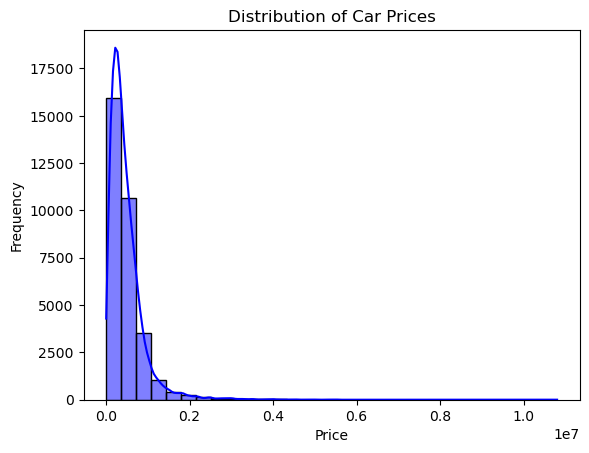

In [15]:
# Plot the distribution of car prices
sns.histplot(df['Price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

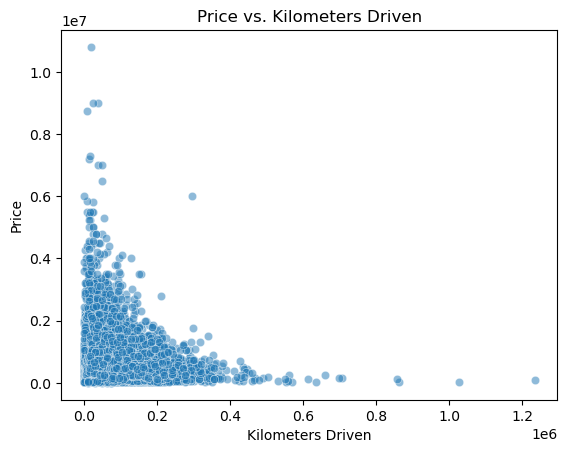

In [16]:
# Plot the relationship between Price and Kilometers
sns.scatterplot(x='Kilometers', y='Price', data=df, alpha=0.5)
plt.title('Price vs. Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.show()

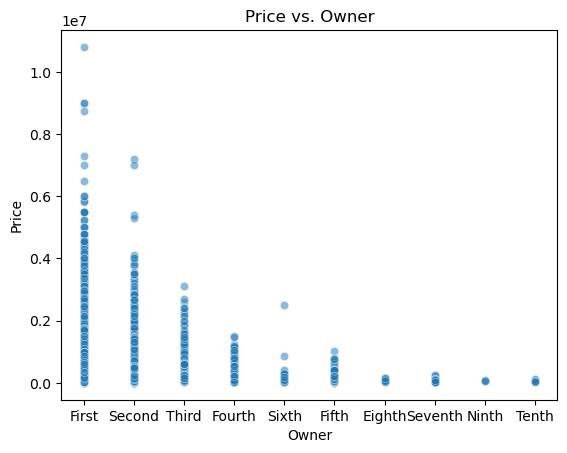

In [17]:
# Plot the relationship between Price and Owner
sns.scatterplot(x='Owner', y='Price', data=df, alpha=0.5)
plt.title('Price vs. Owner')
plt.xlabel('Owner')
plt.ylabel('Price')
plt.show()

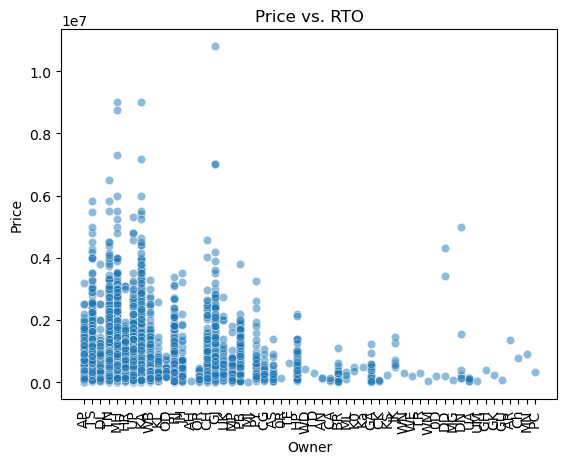

In [18]:
# Plot the relationship between Price and RTO
sns.scatterplot(x='RTO', y='Price', data=df, alpha=0.5)
plt.title('Price vs. RTO')
plt.xlabel('Owner')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

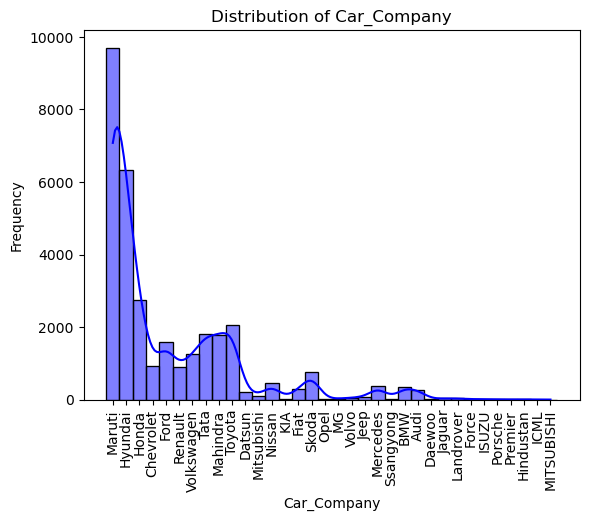

In [19]:
# Plot the distribution of car prices
sns.histplot(df['Car_Company'], bins=30, kde= True, color='blue')
plt.title('Distribution of Car_Company')
plt.xlabel('Car_Company')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

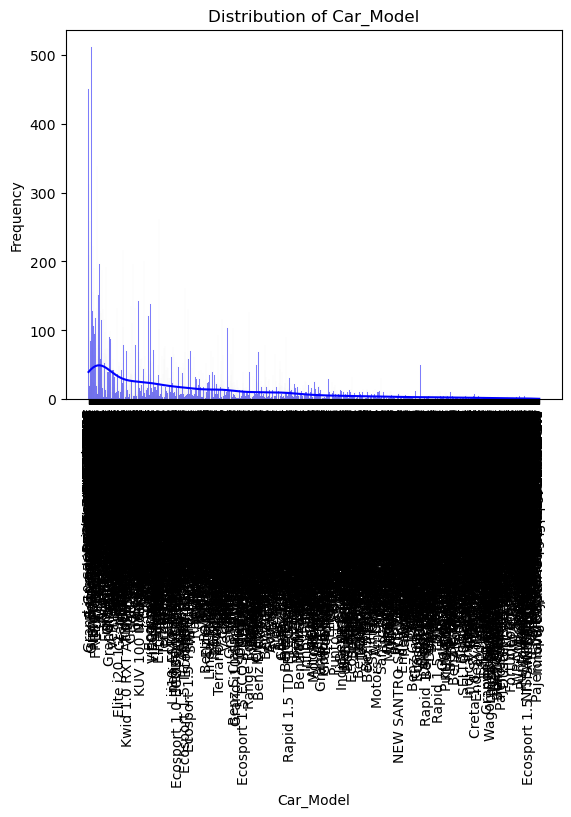

In [20]:
# Plot the distribution of car prices
sns.histplot(df['Car_Model'], bins=30, kde = True, color='blue')
plt.title('Distribution of Car_Model')
plt.xlabel('Car_Model')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Feature Engineering

In [21]:
#Handling missing values
mode_imputer = SimpleImputer(strategy = 'most_frequent')
df["Transmission"] = mode_imputer.fit_transform(df[["Transmission"]]).ravel()

#Feature Encoding
df["Transmission"] = df["Transmission"].map({"AUTOMATIC":0,"MANUAL":1})

# List of columns to be label encoded
columns_to_encode = ["Owner", "Fuel_Type", "Car_Company"]

# Loop through the columns and create dummy variables
for column in columns_to_encode:
    dummies = pd.get_dummies(df[column], drop_first=True).astype(int)
    df = pd.concat([df, dummies], axis='columns')

# Drop the original columns after encoding
df.drop(columns_to_encode, axis='columns', inplace=True)
df.drop(["city","RTO","Insurance_Type"], axis='columns', inplace=True)

#Scaling down target variable for save the computational resources
df["Price"] = df["Price"]/100000

#Handling skewness for Rating feature with Root Transformation
df['Rating'] = df['Rating']**(3.3)

df.head()

,Price,Rating,Kilometers,Transmission,Car_Model,Car_Age,Fifth,First,Fourth,Ninth,...,Opel,Porsche,Premier,Renault,Skoda,Ssangyong,Tata,Toyota,Volkswagen,Volvo
0,1.74699,97.005860,34854.0,1,Alto LXI,14.12,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.33999,113.952185,39541.0,1,Wagon R 1.0 VXI,10.96,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.53199,123.153257,23233.0,1,Wagon R 1.0 VXI,10.29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.37899,132.859873,27748.0,1,Eon D LITE PLUS,10.62,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.00699,132.859873,12238.0,1,Eon ERA PLUS,6.87,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#X&Y

X = df.drop("Price",axis=1)
y= df["Price"]
print(X.shape)
X.head()

(32158, 52)


,Rating,Kilometers,Transmission,Car_Model,Car_Age,Fifth,First,Fourth,Ninth,Second,...,Opel,Porsche,Premier,Renault,Skoda,Ssangyong,Tata,Toyota,Volkswagen,Volvo
0,97.005860,34854.0,1,Alto LXI,14.12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,113.952185,39541.0,1,Wagon R 1.0 VXI,10.96,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,123.153257,23233.0,1,Wagon R 1.0 VXI,10.29,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,132.859873,27748.0,1,Eon D LITE PLUS,10.62,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,132.859873,12238.0,1,Eon ERA PLUS,6.87,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Checking best random state for the modelling

In [23]:
# Define a variable to control whether to run the cell or not

skip_cell = True 

if not skip_cell:
    Train = []
    Test = []
    CV = []
    for i in range(1,100):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
        best_random = LinearRegression()
        best_random.fit(X_train,y_train)
        ypred_train = best_random.predict(X_train)
        ypred_test  = best_random.predict(X_test)
        Train.append(best_random.score(X_train,y_train))
        Test.append(best_random.score(X_test,y_test))
        CV.append(cross_val_score(best_random,X,y, cv=5).mean())
    em = pd.DataFrame({"Train":Train,"Test":Test,"CV":CV})
    gm = em[(abs(em["Train"]-em["Train"])<=0.5)]
    print("best random state number is :",gm[gm["Test"]==gm["Test"].max()].index.to_list()[0])
    print("This cell is being executed.")
else:
    print("This cell is skipped.")

This cell is skipped.


In [24]:
#best random state number is after running test for best random state: 49

#Train test Split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =1)

# Target mean encoding

In [25]:
# Combine X_train and y_train to calculate means
train_data = pd.concat([X_train, y_train], axis=1)

# Performing target encoding on X_test & X_Train
#Car_Model
target_means_Car_Model = train_data.groupby('Car_Model')['Price'].mean()
X_train['Car_Model'] = X_train['Car_Model'].map(target_means_Car_Model)
X_test['Car_Model'] = X_test['Car_Model'].map(target_means_Car_Model)
global_mean_Car_Model = y_train.mean()
if X_test['Car_Model'].isnull().sum()>0:
    X_test['Car_Model'].fillna(global_mean_Car_Model, inplace=True)

#Treating origninal X with traget means for cross validation to prevent data leakage

X['Car_Model'] = X['Car_Model'].map(target_means_Car_Model)
if X['Car_Model'].isnull().sum()>0:
    X['Car_Model'].fillna(global_mean_Car_Model, inplace=True)

In [26]:
#Feature Scaling
Feat_scaling = ["Kilometers"]
sc = StandardScaler()
X_train[Feat_scaling] = sc.fit_transform(X_train[Feat_scaling])
X_test[Feat_scaling] = sc.transform(X_test[Feat_scaling])
X[Feat_scaling] = sc.transform(X[Feat_scaling])


from sklearn.decomposition import PCA
pca_model = PCA(n_components = .95)
X_pca_train = pca_model.fit_transform(X_train)
X_pca_test = pca_model.transform(X_test)
X_pca = pca_model.transform(X)
pca_model.explained_variance_ratio_

# Checking it with Linear model

In [28]:
#random Forest for Regression 

from sklearn.ensemble import RandomForestRegressor
# Initialize the Random Forest Regressor
model_RF = RandomForestRegressor(n_estimators=40, random_state=20,min_samples_split=15,max_depth=20)

# Train the model
model_RF.fit(X_train, y_train)

# Make predictions
ypred_train = model_RF.predict(X_train)
ypred_test  = model_RF.predict(X_test)

#Evaluate
print("train R2",model_RF.score(X_train,y_train))
print("test R2",model_RF.score(X_test,y_test))
print('cross_val_accuracy',cross_val_score(model_RF, X, y, cv = 5,scoring='r2').mean())


train R2 0.9662569700466879
test R2 0.766633356175886
cross_val_accuracy 0.8962231939884949


In [29]:
Linear_model = LinearRegression()
Linear_model.fit(X_train,y_train)
ypred_train = Linear_model.predict(X_train)
ypred_test  = Linear_model.predict(X_test)
print("train R2",Linear_model.score(X_train,y_train))
print("test R2",Linear_model.score(X_test,y_test))
print('cross_val_accuracy',cross_val_score(Linear_model, X, y, cv = 5,scoring='r2').mean())

train R2 0.9157541307984561
test R2 0.7378505399387716
cross_val_accuracy 0.8688842612621727


# Desiginig the ANN model

In [ ]:
#Building Deep Nural Network
def cross_regressor():
    Ann = Sequential()
    Ann.add(Dense(input_dim = 111, units = 210, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.add(Dense(units = 90, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.add(Dense(units = 60, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.add(Dense(units = 110, kernel_initializer = tf.keras.initializers.Orthogonal(gain=1.0), activation = 'relu'))
    Ann.add(Dense(units = 70, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
    Ann.compile( optimizer = 'adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'r2_score'])
    return Ann

In [ ]:
#Checking for ANN Stracture
warnings.filterwarnings("ignore")

ANN = cross_regressor()
ANN.summary()

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
ANN.fit(X_train,y_train, epochs = 150, batch_size =5,callbacks=[early_stopping],validation_split=0.1)

In [ ]:
#Model evaluation

Test_prediction = ANN.predict(X_test)
Train_prediction = ANN.predict(X_train)
print("Test R2 ",r2_score(y_test,Test_prediction))
print("Train R2 ",r2_score(y_train,Train_prediction))


In [ ]:
Ann_regressor = KerasRegressor(model=ANN, epochs=100, batch_size=5,
                               validation_split=0.1, callbacks=[early_stopping])

# Checking cross Validation 

In [ ]:
# Perform cross-validation on the pipeline
cross_val_accuracy = cross_val_score(Ann_regressor, X, y, cv = 5,scoring='r2')

# Print the cross-validation scores
print(cross_val_accuracy)

In [ ]:
print("Test R2 ",r2_score(y_test,Test_prediction))
print("Train R2 ",r2_score(y_train,Train_prediction))
print("Cross Validation Score", cross_val_accuracy,"Mean", cross_val_accuracy.mean())

In [ ]:
#ANN.save("car_regressor_updated_CV.keras")